## Download the Input File

In [1]:
import requests
url = "https://drive.google.com/uc?id=140fl292Ofs6tmEJzIFUPGo97AdIIO3vi&export=download"
r = requests.get(url)
with open('input.zip', 'wb') as f:
    f.write(r.content)

In [2]:
!mkdir outputs

A subdirectory or file outputs already exists.


In [3]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 21, 18

In [4]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


Overwriting coco_names.py


In [5]:
%%writefile detect_utils.py
import torchvision.transforms as transforms
import cv2
import numpy as np

from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names

# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    outputs = model(image) # get the predictions on the image

    # get all the predicited class names
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]

    # get score for all the predicted objects
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

def draw_boxes(boxes, classes, labels, image):
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image


Overwriting detect_utils.py


## Object Detection in Images

In [20]:
%%writefile detect_img.py
import torchvision
import torch
import argparse
import cv2
import detect_utils

from PIL import Image

# construct the argument parser
parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', help='path to input image/video')
args = vars(parser.parse_args())

# define the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# load the model on to the computation device
model.eval().to(device)
torch.save(model.state_dict(), 'Model.pth')

# read the image and run the inference for detections
image = Image.open(args['input'])
boxes, classes, labels = detect_utils.predict(image, model, device, 0.7)
image = detect_utils.draw_boxes(boxes, classes, labels, image)
# cv2.imshow('Image', image)
save_name = f"{args['input'].split('/')[-1].split('.')[0]}"
cv2.imwrite(f"outputs/{save_name}.jpg", image)
# cv2.waitKey(0)

Overwriting detect_img.py


In [1]:
import os
import torch
from PIL import Image
import torchvision.transforms as T

class MyRatDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        """
        Args:
            root (string): Path to the subset folder (e.g. 'new_dataset/train').
                           This folder must contain 'images/' and 'labels/' subfolders.
            transforms (callable, optional): A function/transform that takes in
                                             a PIL image and returns a transformed version.
        """
        self.root = root
        self.transforms = transforms
        
        self.img_dir = os.path.join(root, "images")
        self.lbl_dir = os.path.join(root, "labels")
        
        # Collect image file names
        self.imgs = [f for f in os.listdir(self.img_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.imgs.sort()  # optional sorting

    def __getitem__(self, idx):
        # Image file path
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        # Load the image
        img = Image.open(img_path).convert("RGB")
        
        # Corresponding label file path
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.lbl_dir, label_name)
        
        boxes = []
        labels = []
        
        # Read the label file if it exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        # e.g. class_id, x_min, y_min, x_max, y_max
                        continue
                    class_id = int(parts[0])
                    xmin = float(parts[1])
                    ymin = float(parts[2])
                    xmax = float(parts[3])
                    ymax = float(parts[4])
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(class_id)



In [10]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_loss_cls = 0.0
    epoch_loss_box = 0.0
    epoch_loss_obj = 0.0
    epoch_loss_rpn = 0.0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Accumulate detailed losses
        epoch_loss += losses.item()
        epoch_loss_cls += loss_dict['loss_classifier'].item()
        epoch_loss_box += loss_dict['loss_box_reg'].item()
        epoch_loss_obj += loss_dict['loss_objectness'].item()
        epoch_loss_rpn += loss_dict['loss_rpn_box_reg'].item()

    # Print detailed epoch losses
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Total Loss: {epoch_loss:.4f}, "
          f"Cls: {epoch_loss_cls:.4f}, "
          f"Box: {epoch_loss_box:.4f}, "
          f"Obj: {epoch_loss_obj:.4f}, "
          f"RPN: {epoch_loss_rpn:.4f}")

    # Save model after each epoch
    save_path = f"fasterrcnn_rat_detection_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")



Epoch 1/10: Total Loss: 2.5234, Cls: 0.0000, Box: 0.0000, Obj: 2.1098, RPN: 0.4136
Model saved to fasterrcnn_rat_detection_epoch_1.pth
Epoch 2/10: Total Loss: 0.6716, Cls: 0.0000, Box: 0.0000, Obj: 0.3326, RPN: 0.3390
Model saved to fasterrcnn_rat_detection_epoch_2.pth
Epoch 3/10: Total Loss: 0.4572, Cls: 0.0000, Box: 0.0000, Obj: 0.1585, RPN: 0.2987
Model saved to fasterrcnn_rat_detection_epoch_3.pth
Epoch 4/10: Total Loss: 0.3973, Cls: 0.0000, Box: 0.0000, Obj: 0.1099, RPN: 0.2874
Model saved to fasterrcnn_rat_detection_epoch_4.pth
Epoch 5/10: Total Loss: 0.3464, Cls: 0.0000, Box: 0.0000, Obj: 0.0981, RPN: 0.2483
Model saved to fasterrcnn_rat_detection_epoch_5.pth
Epoch 6/10: Total Loss: 0.3221, Cls: 0.0000, Box: 0.0000, Obj: 0.0893, RPN: 0.2328
Model saved to fasterrcnn_rat_detection_epoch_6.pth
Epoch 7/10: Total Loss: 0.3107, Cls: 0.0000, Box: 0.0000, Obj: 0.0852, RPN: 0.2255
Model saved to fasterrcnn_rat_detection_epoch_7.pth
Epoch 8/10: Total Loss: 0.2718, Cls: 0.0000, Box: 0.000

In [ ]:
import cv2
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define your device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform that was used during training
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def predict(image_path, model, device, threshold=0.7):
    # Load image using PIL and convert to RGB
    img = Image.open(image_path).convert("RGB")
    # Save a copy of the original image for visualization (as a NumPy array)
    orig_img = np.array(img)
    
    # Apply transforms and add a batch dimension
    img_tensor = transform(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)

    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Since batch size is 1, extract the first result
    output = outputs[0]
    boxes = output['boxes'].cpu().numpy()  # shape: [N, 4]
    scores = output['scores'].cpu().numpy()  # shape: [N]
    labels = output['labels'].cpu().numpy()  # shape: [N]
    
    # Filter detections below the confidence threshold
    keep = scores >= threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]
    
    return orig_img, boxes, scores, labels

if __name__ == "__main__":
    # 1. Load the pre-trained model and modify it for 2 classes: background and rat.
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    
    # 2. Load your fine-tuned model weights (adjust the path to your saved model)
    model.load_state_dict(torch.load("fasterrcnn_rat_detection_epoch_10.pth", map_location=device))
    model.to(device)
    
    # 3. Set the path to your test image (adjust the path)
    image_path = "C:\\Machine Learning\\Rat Tracking using TensorFlow\\FastRcNN\\new_dataset\\test\\images\\Baseline_frame_000253.jpg"
    
    # 4. Run prediction
    orig_img, boxes, scores, labels = predict(image_path, model, device, threshold=0.7)
    print(labels)
    
    # 5. Draw bounding boxes and scores on the image
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig_img, f"Rat: {score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # 6. Display the image with predictions
    cv2.imshow("Predictions", orig_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


[]


# SSD

In [1]:
from torchinfo import summary
import torchvision

model = torchvision.models.mobilenet_v3_small(pretrained=True)
quantized = torchvision.models.quantization.mobilenet_v3_large(pretrained=True)

summary(model, input_size=(1, 3, 640, 480))  # Specify batch_size and image dimensions

c:\Users\mzarrar\AppData\Local\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mzarrar\AppData\Local\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\mzarrar\AppData\Local\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 1000]                 --
├─Sequential: 1-1                                  [1, 576, 20, 15]          --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 320, 240]         --
│    │    └─Conv2d: 3-1                            [1, 16, 320, 240]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 320, 240]         32
│    │    └─Hardswish: 3-3                         [1, 16, 320, 240]         --
│    └─InvertedResidual: 2-2                       [1, 16, 160, 120]         --
│    │    └─Sequential: 3-4                        [1, 16, 160, 120]         744
│    └─InvertedResidual: 2-3                       [1, 24, 80, 60]           --
│    │    └─Sequential: 3-5                        [1, 24, 80, 60]           3,864
│    └─InvertedResidual: 2-4                       [1, 24, 80, 60]           --
│    │    └─Sequential: 3-6   

# FastRCNN Large

In [49]:
import os
import torch
import random
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

import torchvision.transforms as T

class MyRatDataset(Dataset):
    """
    A dataset that reads images and YOLO-format annotations from a folder.
    Expected structure:
        root/
          images/
            img1.jpg
            img2.jpg
            ...
          labels/
            img1.txt
            img2.txt
            ...
    Each label file should contain lines (YOLO format):
        class_id  x_center_norm  y_center_norm  width_norm  height_norm
    In this version, we also create negative samples on the fly.
    With a certain probability, we "remove" the rat(s) by filling the bounding box regions with random noise.
    The resulting image is treated as a negative sample (with no bounding boxes).
    """
    def __init__(self, root, transforms=None, negative_sample_ratio=0.3):
        """
        Args:
            root (str): Path to the subset folder (e.g., 'new_dataset/train').
                        Must contain 'images/' and 'labels/' subfolders.
            transforms (callable, optional): Transformations to apply to the PIL image.
            negative_sample_ratio (float): The probability (0 to 1) of generating a negative sample from a positive image.
        """
        self.root = root
        self.transforms = transforms
        self.negative_sample_ratio = negative_sample_ratio
        
        self.img_dir = os.path.join(root, "images")
        self.lbl_dir = os.path.join(root, "labels")
        
        # Collect image file names
        self.imgs = [f for f in os.listdir(self.img_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.imgs.sort()  # for consistent ordering

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Load image
        img_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        # Load annotations from the corresponding label file
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.lbl_dir, label_name)
        
        boxes = []
        labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    # YOLO format: class_id, x_center, y_center, width, height (all normalized)
                    class_id = int(parts[0]) + 1
                    x_center_norm = float(parts[1])
                    y_center_norm = float(parts[2])
                    width_norm    = float(parts[3])
                    height_norm   = float(parts[4])
                    
                    # Convert normalized coords to absolute pixel coordinates
                    x_center = x_center_norm * w
                    y_center = y_center_norm * h
                    box_width = width_norm * w
                    box_height = height_norm * h
                    x_min = x_center - box_width / 2
                    y_min = y_center - box_height / 2
                    x_max = x_center + box_width / 2
                    y_max = y_center + box_height / 2
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)
        
        # If no annotations, treat image as a negative sample naturally
        if len(boxes) == 0:
            boxes = torch.empty((0, 4), dtype=torch.float32)
            labels = torch.empty((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # Decide whether to generate a negative sample from this image
        # (only if there are boxes, because otherwise it's already negative)
        if boxes.shape[0] > 0 and random.random() < self.negative_sample_ratio:
            # Generate negative sample by filling each bounding box with random noise
            img = self.generate_negative_sample(img, boxes)
            # Set target to have no boxes or labels
            boxes = torch.empty((0, 4), dtype=torch.float32)
            labels = torch.empty((0,), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        if boxes.size(0) > 0:
            area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        else:
            area = torch.empty((0,), dtype=torch.float32)
        iscrowd = torch.zeros((labels.shape[0],), dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

    def generate_negative_sample(self, img, boxes):
        """
        Generate a negative sample by filling the regions of each bounding box in the image with random noise.
        Args:
            img (PIL.Image): The original image.
            boxes (Tensor): Tensor of shape [N, 4] with bounding box coordinates in absolute pixel values.
        Returns:
            PIL.Image: The image with the rat regions replaced with noise.
        """
        # Convert PIL image to NumPy array
        img_np = np.array(img)
        # Iterate through each box and fill the region with random noise
        for box in boxes:
            x_min, y_min, x_max, y_max = box.int().tolist()
            # Clip coordinates to image boundaries
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(img_np.shape[1], x_max)
            y_max = min(img_np.shape[0], y_max)
            if x_max > x_min and y_max > y_min:
                noise = np.random.randint(0, 256, (y_max - y_min, x_max - x_min, 3), dtype=np.uint8)
                img_np[y_min:y_max, x_min:x_max, :] = noise
        # Convert back to PIL image
        return Image.fromarray(img_np)

# Example usage
if __name__ == "__main__":
    import torchvision.transforms as T
    
    # Define transforms: converting image to tensor and normalizing
    transforms = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    
    # Create dataset instance. Adjust root path as needed.
    dataset_root = "new_dataset\\train"  # Folder with subfolders: images/ and labels/
    dataset = MyRatDataset(root=dataset_root, transforms=transforms, negative_sample_ratio=0.3)
    
    # Optionally, inspect a sample
    img, target = dataset[0]
    print("Sample target:", target)
    
    # Create DataLoader
    from torch.utils.data import DataLoader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))
    
    # Iterate over one batch
    for images, targets in dataloader:
        print(f"Batch has {len(images)} images")
        for t in targets:
            print("Boxes:", t["boxes"], "Labels:", t["labels"])
        break


Sample target: {'boxes': tensor([[ 19.0000, 133.2500, 168.0000, 396.7500]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([39261.5000]), 'iscrowd': tensor([0])}
Batch has 4 images
Boxes: tensor([[ 69.0000, 238.5000, 206.0000, 526.5000]]) Labels: tensor([1])
Boxes: tensor([], size=(0, 4)) Labels: tensor([], dtype=torch.int64)
Boxes: tensor([[ 33.0000, 330.7500, 305.0000, 545.2500]]) Labels: tensor([1])
Boxes: tensor([[ 53.0000, 234.7500, 204.0000, 556.2500]]) Labels: tensor([1])


In [50]:
import cv2
import numpy as np

def tensor_to_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Convert a normalized tensor (C x H x W) back to a uint8 image (H x W x 3) for display.
    """
    # Clone and move tensor to CPU
    tensor = tensor.clone().detach().cpu().numpy()
    # Unnormalize: tensor * std + mean (broadcasting over H and W)
    tensor = tensor * np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    # Transpose to H x W x C
    tensor = np.transpose(tensor, (1, 2, 0))
    # Clip values and convert to uint8
    tensor = np.clip(tensor * 255, 0, 255).astype(np.uint8)
    # Convert from RGB (PIL) to BGR (OpenCV)
    img_bgr = cv2.cvtColor(tensor, cv2.COLOR_RGB2BGR)
    return img_bgr

# --- Iterate over one batch and show the images with OpenCV ---
for images, targets in dataloader:
    print(f"Batch has {len(images)} images")
    for idx, (img_tensor, t) in enumerate(zip(images, targets)):
        # Convert tensor to displayable image
        img_disp = tensor_to_image(img_tensor)
        # Print boxes and labels from target
        print("Boxes:", t["boxes"], "Labels:", t["labels"])
        # Show image
        cv2.imshow(f"Image {idx}", img_disp)
    cv2.waitKey(0)  # Wait indefinitely until a key is pressed
    cv2.destroyAllWindows()
    break


Batch has 4 images
Boxes: tensor([[465.0000,  96.2500, 581.0000, 334.7500]]) Labels: tensor([1])
Boxes: tensor([[419.0000,  22.9999, 589.0000, 274.0001]]) Labels: tensor([1])
Boxes: tensor([], size=(0, 4)) Labels: tensor([], dtype=torch.int64)
Boxes: tensor([[244.0000, 220.0001, 432.0000, 391.9999]]) Labels: tensor([1])


In [59]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T

# Assume your custom dataset class MyRatDataset is defined elsewhere.
# It should return images and targets (with keys: "boxes", "labels", etc.)

# Define transforms: converting image to tensor and normalizing.
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# Create training and validation datasets and dataloaders.
train_dataset = MyRatDataset(root="new_dataset\\train", transforms=transforms, negative_sample_ratio=0.3)
val_dataset   = MyRatDataset(root="new_dataset\\valid", transforms=transforms, negative_sample_ratio=0.0)  # No negatives in val (or set as desired)

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: tuple(zip(*batch))
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda batch: tuple(zip(*batch))
)

# --- Load and modify the detection model ---
# Instantiate a Faster R-CNN with a MobileNetV3 Large FPN backbone
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Modify for 2 classes: background (0) and rat (1)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Define optimizer ---
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                              lr=0.005, momentum=0.9, weight_decay=0.0005)

train_losses = []
val_losses = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        epoch_train_loss += losses.item()
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
    
    # Validation loop
    model.train()  # to compute loss with targets
    epoch_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            epoch_val_loss += losses.item()
    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)
    # Save model after each epoch
    save_path = f"fasterrcnn_rat_detection_small_epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

Model saved to fasterrcnn_rat_detection_small_epoch_1.pth
Epoch 1/10: Train Loss: 0.7847, Val Loss: 0.9290
Model saved to fasterrcnn_rat_detection_small_epoch_2.pth
Epoch 2/10: Train Loss: 0.8344, Val Loss: 1.2653
Model saved to fasterrcnn_rat_detection_small_epoch_3.pth
Epoch 3/10: Train Loss: 0.9427, Val Loss: 1.1336
Model saved to fasterrcnn_rat_detection_small_epoch_4.pth
Epoch 4/10: Train Loss: 0.8454, Val Loss: 0.5252
Model saved to fasterrcnn_rat_detection_small_epoch_5.pth
Epoch 5/10: Train Loss: 0.7517, Val Loss: 1.1657
Model saved to fasterrcnn_rat_detection_small_epoch_6.pth
Epoch 6/10: Train Loss: 0.7908, Val Loss: 1.1056
Model saved to fasterrcnn_rat_detection_small_epoch_7.pth
Epoch 7/10: Train Loss: 0.7484, Val Loss: 1.1450
Model saved to fasterrcnn_rat_detection_small_epoch_8.pth
Epoch 8/10: Train Loss: 0.8528, Val Loss: 1.2382
Model saved to fasterrcnn_rat_detection_small_epoch_9.pth
Epoch 9/10: Train Loss: 0.8516, Val Loss: 0.7297
Model saved to fasterrcnn_rat_detecti

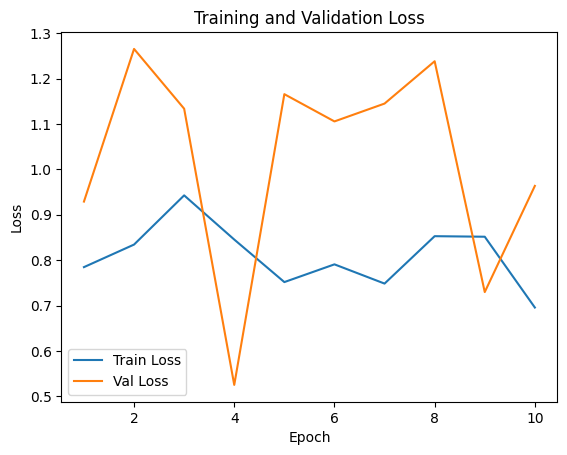

In [60]:
import matplotlib.pyplot as plt

# After your training loop:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [61]:
def predict(image_path, model, device, threshold=0.7):
        # Load image using PIL
        img = Image.open(image_path).convert("RGB")
        orig_img = np.array(img)  # For visualization
        # Apply transforms
        img_tensor = transforms(img).to(device)
        img_tensor = img_tensor.unsqueeze(0)
        
        model.eval()
        with torch.no_grad():
            outputs = model(img_tensor)
        output = outputs[0]
        boxes = output['boxes'].cpu().numpy()
        scores = output['scores'].cpu().numpy()
        labels = output['labels'].cpu().numpy()
        
        # Filter out detections below threshold
        keep = scores >= threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]
        return orig_img, boxes, scores, labels

In [62]:
import cv2
# Replace with your test image path
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
model.to(device)

test_image_path = r"C:\Machine Learning\Rat Tracking using TensorFlow\FastRcNN\new_dataset\test\images\Baseline_frame_000253.jpg"
model_path = r"C:\Machine Learning\Rat Tracking using TensorFlow\FastRcNN\fasterrcnn_rat_detection_small_epoch_10.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

orig_img, boxes, scores, labels = predict(test_image_path, model, device, threshold=0.7)
    
    # Draw bounding boxes on the test image using OpenCV
for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(orig_img, f"Rat: {score:.2f}", (x1, y1-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
cv2.imshow("Predictions", orig_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

c:\Users\mzarrar\AppData\Local\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mzarrar\AppData\Local\miniconda3\envs\tf\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import cv2
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the transform (same as during training)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

device = torch.device("cpu")

# Load and modify the detection model
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)  # 2 classes: background and rat
model.to(device)

# Load saved weights
model_path = r"C:\Machine Learning\Rat Tracking using TensorFlow\FastRcNN\fasterrcnn_rat_detection_small_epoch_10.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model.eval()

def predict(image_input, model, device, threshold=0.7):
    """
    Predict detections on a given image.
    
    Args:
        image_input (str or np.ndarray): If string, treated as file path;
                                           if np.ndarray, treated as an OpenCV BGR image.
        model: The detection model.
        device: Computation device.
        threshold (float): Confidence threshold.
    
    Returns:
        orig_img (np.ndarray): The original image in BGR format.
        boxes (np.ndarray): Array of bounding boxes.
        scores (np.ndarray): Detection scores.
        labels (np.ndarray): Detected labels.
        inference_time_ms (float): Inference time in milliseconds.
    """
    # Check input type and convert accordingly
    if isinstance(image_input, np.ndarray):
        # image_input is a frame (BGR)
        pil_img = Image.fromarray(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
        orig_img = image_input.copy()  # keep a copy in BGR for display
    elif isinstance(image_input, str):
        pil_img = Image.open(image_input).convert("RGB")
        orig_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    else:
        raise ValueError("Unsupported type for image_input. Must be str or np.ndarray.")
    
    # Apply transforms to create a tensor
    img_tensor = transform(pil_img).to(device)
    img_tensor = img_tensor.unsqueeze(0)  # add batch dimension

    # Measure inference time using OpenCV ticks
    start = cv2.getTickCount()
    with torch.no_grad():
        outputs = model(img_tensor)
    end = cv2.getTickCount()
    inference_time_ms = (end - start) / cv2.getTickFrequency() * 1000.0

    output = outputs[0]
    boxes = output['boxes'].cpu().numpy()
    scores = output['scores'].cpu().numpy()
    labels = output['labels'].cpu().numpy()

    # Filter out detections below threshold
    keep = scores >= threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    return orig_img, boxes, scores, labels, inference_time_ms

def main():
    video_path = r"C:\Machine Learning\Rat Tracking using TensorFlow\Video\BaselineDark.mp4"
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Predict on the current frame (frame is a NumPy array in BGR format)
        orig_img, boxes, scores, labels, inf_time = predict(frame, model, device, threshold=0.2)
        print("Labels:", labels)
        print("Inference time (ms):", inf_time)

        # Draw bounding boxes and labels on the frame
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.astype(int)
            cv2.rectangle(orig_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(orig_img, f"Rat: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Draw inference time on the frame
        cv2.putText(orig_img, f"Inference: {inf_time:.1f} ms", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
        
        # Display the frame with predictions
        cv2.imshow("Predictions", orig_img)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Labels: [1]
Inference time (ms): 183.09449999999998
Labels: [1]
Inference time (ms): 128.541
Labels: [1]
Inference time (ms): 109.5261
Labels: [1]
Inference time (ms): 87.0966
Labels: [1]
Inference time (ms): 88.0605
Labels: [1]
Inference time (ms): 90.4629
Labels: [1]
Inference time (ms): 85.6326
Labels: [1]
Inference time (ms): 85.77600000000001
Labels: [1]
Inference time (ms): 89.6277
Labels: [1]
Inference time (ms): 83.4615
Labels: [1]
Inference time (ms): 86.1966
Labels: [1]
Inference time (ms): 90.81269999999999
Labels: [1]
Inference time (ms): 85.50439999999999
Labels: [1]
Inference time (ms): 85.46
Labels: [1]
Inference time (ms): 92.92609999999999
Labels: []
Inference time (ms): 69.2402
Labels: []
Inference time (ms): 71.1932
Labels: []
Inference time (ms): 74.5106
Labels: []
Inference time (ms): 71.4948
Labels: []
Inference time (ms): 68.59410000000001
Labels: []
Inference time (ms): 73.3197
Labels: []
Inference time (ms): 69.1036
Labels: []
Inference time (ms): 69.2346999999